In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np

## Extract data functions

In [2]:
def extract_data_state(base_directory, state):
    '''
    Extract the data from the TCR Data folder for a given state (F or R)

    ***Parameters***
    state: str, the state of the data to extract (F or R)

    ***Returns***
    data_list: list, a list of dataframes containing the data for the given scale
    ''' 
    data_list = []
    file_list = []
    for i in range(1, 22): # go through all the 21 patients
        file_folder = os.path.join(base_directory, f"Pt{i}")
        if os.path.exists(file_folder):
            file_list = [f for f in os.listdir(file_folder) if state in f] # extract the files with the given state
            for file in file_list:
                file_path = os.path.join(file_folder, file)
                data = pd.read_csv(file_path)
                data_list.append(data)
    return file_list, data_list

def extract_data_patients(base_directory, num):
    '''
    Extract the data from the TCR Data folder for a given patient

    ***Parameters***
    num: int, the patient number

    ***Returns***
    data_list: list, a list of dataframes containing the data for the given scale
    ''' 
    data_list = []
    file_list = []
    file_folder = os.path.join(base_directory, f"Pt{num}")
    if os.path.exists(file_folder):
        file_list = [f for f in os.listdir(file_folder) if 'metadata' not in f] # will skip the metadata file
        for file in file_list:
            file_path = os.path.join(file_folder, file)
            data = pd.read_csv(file_path)
            data_list.append(data)
    return file_list, data_list


## Load data

In [3]:
# loading all the Flare time points
base_directory = "D:/desktop/PCM__EHR/pigeon/data/TCR Data" # should be the path to the TCR Data folder on your device

file_list_F, data_list_F = extract_data_state(base_directory, 'F')
file_list_R, data_list_R = extract_data_state(base_directory, 'R')

# concatenate all the data into one dataframe
data_F = pd.concat(data_list_F, ignore_index=True)
data_R = pd.concat(data_list_R, ignore_index=True)

data_F.head()

,count,freq,cdr3nt,cdr3aa,v,d,j,VEnd,DStart,DEnd,JStart
0,1,0.000007,TGCAGTGCCAGCAGTTTAGGGACAGGGGTAAGGTACGAGCAGTACTTC,CSASSLGTGVRYEQYF,TRBV20-1,TRBD1,TRBJ2-7,8,NaN,2.0,33
1,1,0.000007,TGCAGTGCCAGCATGAGCGGGTACGAGCAGTACTTC,CSASMSGYEQYF,TRBV20-1,TRBD2,TRBJ2-7,8,NaN,2.0,21
2,1,0.000007,TGCAGTGCCATATGGGTGCAGGGCGAGCAGTACTTC,CSAIWVQGEQYF,TRBV20-1,"TRBD1, TRBD2",TRBJ2-1,8,NaN,2.0,24
3,1,0.000007,TGCAGTGCGAGGACAGGGGTGAGCTACGAGCAGTACTTC,CSARTGVSYEQYF,TRBV20-1,TRBD1,TRBJ2-1,8,NaN,2.0,27
4,1,0.000007,TGCAGTGCTAAACTGTGGGGGGACTCGGCCATGTATCTCTGTGCCA...,CSAKLWGDSAMYLCASSSLRTAETQYF,TRBV20-1,"TRBD1, TRBD2",TRBJ2-5,10,NaN,1.0,65


## Plot the freqs

In [5]:
def plot_gene_usage_single_state(data, genetype, state, head=True):
    '''
    Plot the gene usage for a one state

    ***Parameters***
    data: pd.DataFrame, the data to plot
    genetype: str, the gene type to plot
    state: str, the state to plot (e.g., 'Flare')
    head: bool, whether to plot the top 20 or bottom 20 gene usages (default is True)

    ***Returns***
    None
    '''
    if genetype == 'V':
        gene_usage = data.groupby('v')['freq'].sum()
        if head:
            gene_usage = gene_usage.nlargest(20)
        else:
            gene_usage = gene_usage.nsmallest(20)
    elif genetype == 'J':
        gene_usage = data.groupby('j')['freq'].sum()
    elif genetype == 'D':
        gene_usage = data.dropna(subset=['d']).groupby('d')['freq'].sum()
    
    if state == 'Flare':
        gene_usage.plot(kind='bar', color='coral')
    else:
        gene_usage.plot(kind='bar', color='skyblue')
    plt.xlabel(f'{genetype} Gene')
    plt.ylabel('Total Frequency')
    plt.title(f'{genetype} Gene Usage Frequency among all {state} state')
    plt.show()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_gene_usage_cross_section(data_F, data_R, genetype, head=True):
    '''
    Plot the V gene usage frequency for the given data

    ***Parameters***
    data_F: pd.DataFrame, the data for the Flare state
    data_R: pd.DataFrame, the data for the Remission state
    genetype: str, the gene type to plot

    ***Returns***
    None
    '''
    # Extract the gene usage frequency for the Flare and Remission time points
    if genetype == 'V':
        gene_usage_F = data_F.groupby('v')['freq'].sum()
        gene_usage_R = data_R.groupby('v')['freq'].sum()
    elif genetype == 'J':
        gene_usage_F = data_F.groupby('j')['freq'].sum()
        gene_usage_R = data_R.groupby('j')['freq'].sum()
    elif genetype == 'D':
        gene_usage_F = data_F.dropna(subset=['d']).groupby('d')['freq'].sum()
        gene_usage_R = data_R.dropna(subset=['d']).groupby('d')['freq'].sum()

    # Sort and select top or bottom 20 genes if genetype is 'V'
    if genetype == 'V':
        if head:
            gene_usage_F = gene_usage_F.nlargest(20)
            gene_usage_R = gene_usage_R.nlargest(20)
        else:
            gene_usage_F = gene_usage_F.nsmallest(20)
            gene_usage_R = gene_usage_R.nsmallest(20)

    # get the index of the genes
    genes = list(set(gene_usage_F.index).union(set(gene_usage_R.index)))
    values_F = [gene_usage_F.get(gene, 0) for gene in genes]
    values_R = [gene_usage_R.get(gene, 0) for gene in genes]
    values_diff = [f - r for f, r in zip(values_F, values_R)]

    # Sort by difference
    sorted_indices = np.argsort(values_diff)[::-1]
    genes = [genes[i] for i in sorted_indices]
    values_F = [values_F[i] for i in sorted_indices]
    values_R = [values_R[i] for i in sorted_indices]
    values_diff = [values_diff[i] for i in sorted_indices]

    # plot the gene usage frequency
    bar_width = 0.35
    index = np.arange(len(genes))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

    # Plot for Flare and Remission
    bar_F = ax1.bar(index, values_F, bar_width, label='Flare', color='coral')
    bar_R = ax1.bar(index + bar_width, values_R, bar_width, label='Remission', color='lightblue')

    ax1.set_xlabel(f'{genetype} Gene')
    ax1.set_ylabel('Total Frequency')
    ax1.set_title(f'{genetype} Gene Usage Frequency among All Timepoints')
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(genes, rotation=90)
    ax1.legend()

    # Plot for difference
    bar_diff = ax2.bar(index, values_diff, bar_width, label='Difference (Flare - Remission)', color='purple')

    ax2.set_xlabel(f'{genetype} Gene')
    ax2.set_ylabel('Frequency Difference')
    ax2.set_title(f'{genetype} Gene Usage Frequency Difference (Flare - Remission)')
    ax2.set_xticks(index)
    ax2.set_xticklabels(genes, rotation=90)
    ax2.legend()

    plt.tight_layout()
    plt.show()

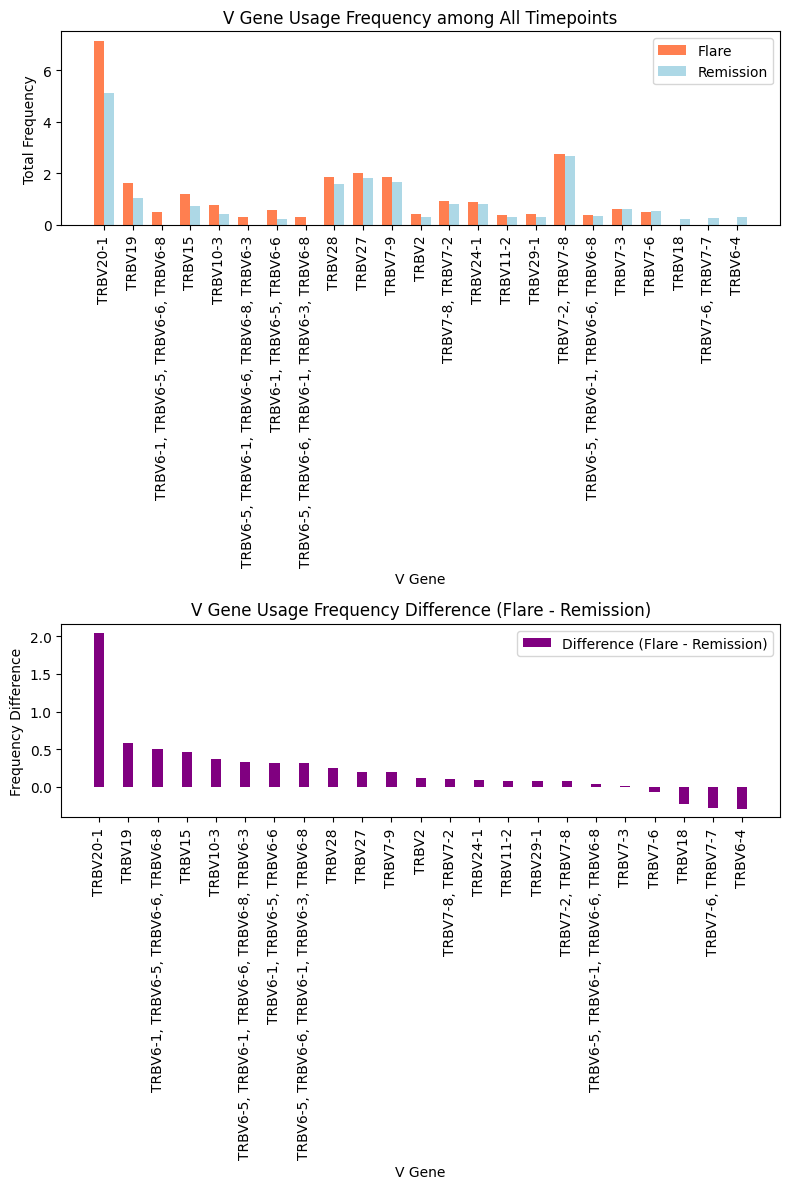

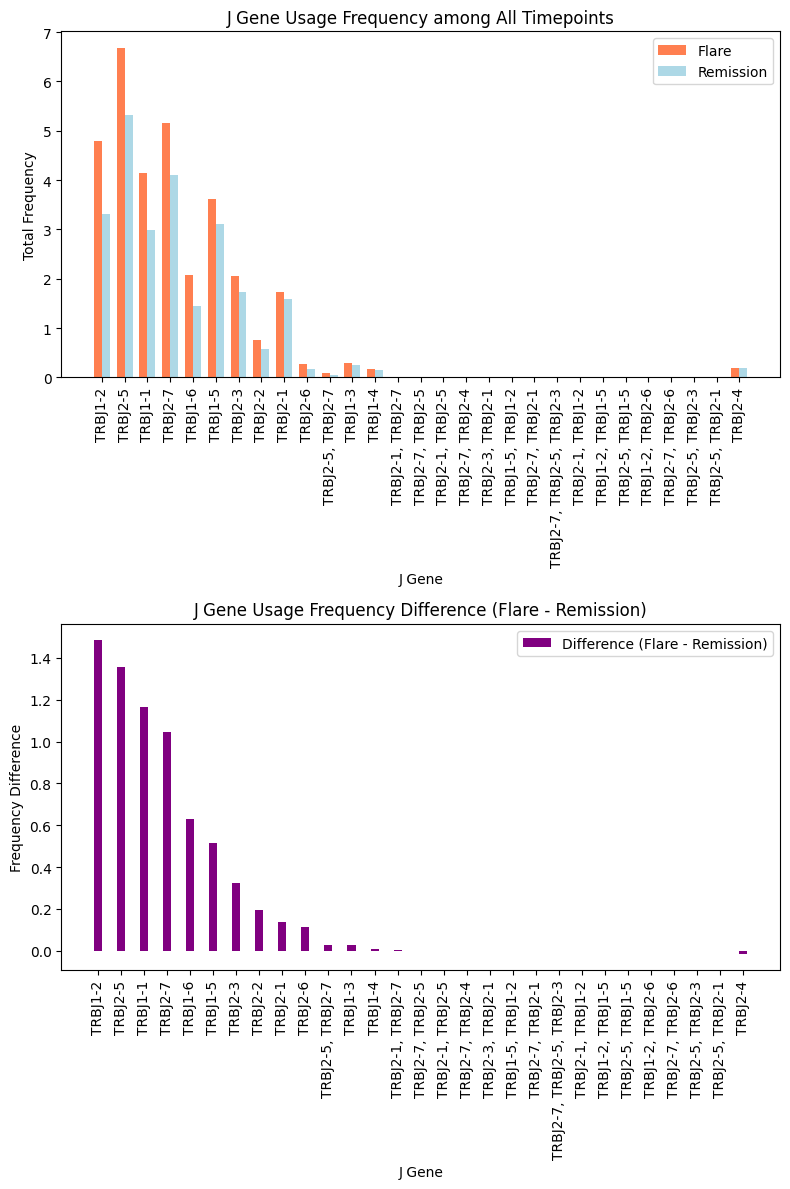

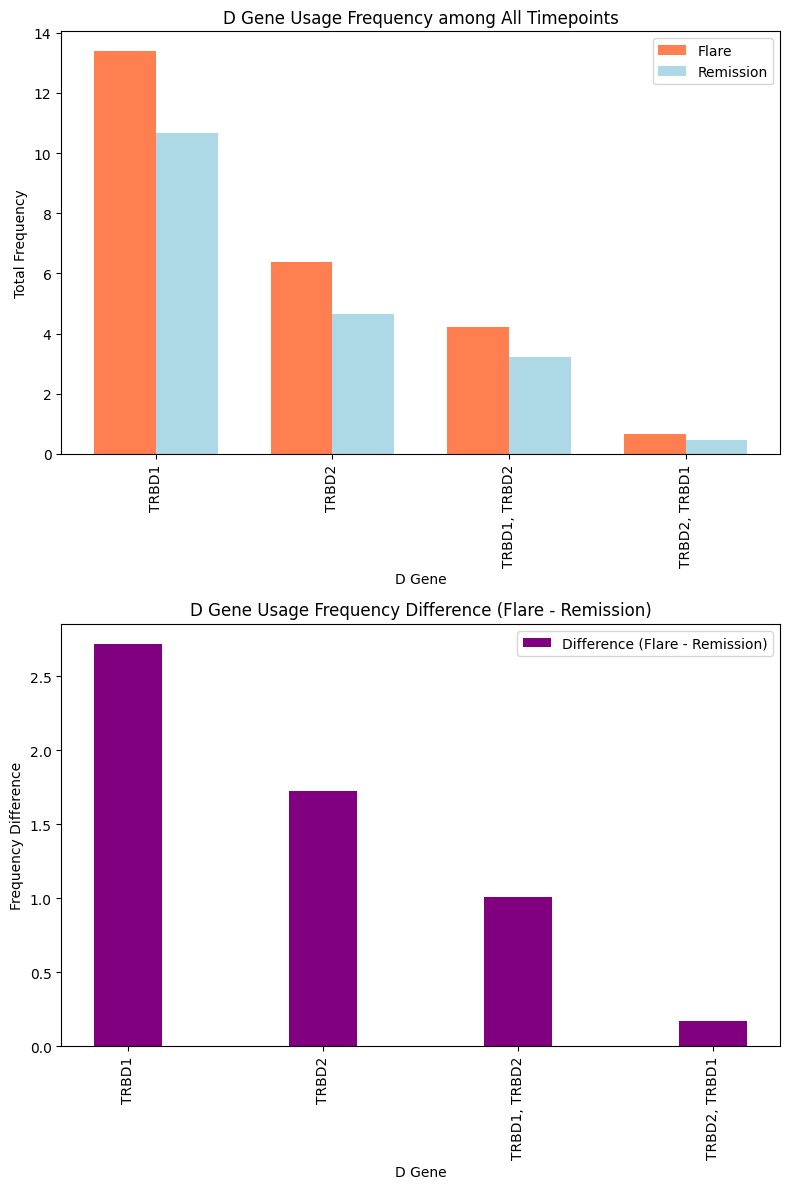

In [9]:
'''This is the main function'''

plot_gene_usage_cross_section(data_F, data_R, 'V')
plot_gene_usage_cross_section(data_F, data_R, 'J')
plot_gene_usage_cross_section(data_F, data_R, 'D')

# plot_gene_usage_single_state(data_F, 'V', 'Flare', head=True)
# plot_gene_usage_single_state(data_F, 'V', 'Flare', head=False)
# plot_gene_usage_single_state(data_F, 'J', 'Flare')
# plot_gene_usage_single_state(data_F, 'D', 'Flare')

# plot_gene_usage_single_state(data_R, 'V', 'Remission', head=True)
# plot_gene_usage_single_state(data_R, 'V', 'Remission', head=False)
# plot_gene_usage_single_state(data_R, 'J', 'Remission')
# plot_gene_usage_single_state(data_R, 'D', 'Remission')
